In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns


# FOR FIGURES #
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = '14'

    This model predict temperatur at 2021-08-31 in 16.8, the acutal value is 16.6. The data are from Hamburg (Deutsche Seewarte).	

# Define functions

In [2]:
def plot_temperature(df, title='Hamburg (Deutsche Seewarte) station mean temperatures', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Mean Temperature')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

In [3]:
def fit_a_model(X, y, model):
    
    """
    For a linear regression model and return the fit
    """
    
    if model=='linear regression':

     pipeline_model = Pipeline([
                    ("logistic regression", LinearRegression()),
                              ])
    m=pipeline_model.fit(X, y)
      
    print(f'Model used:  {model}')    
    
    return m 

# Read Full the data into a DataFrame

In [4]:
df=pd.read_csv('ECA_blended_custom_Hamburg/hamburg.csv',delimiter=',', parse_dates=True )

## Clean the data

In [5]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

In [6]:
df=df.loc[df['Q_TG'] == 0]

In [7]:
df=df.drop(columns=['SOUID', 'Q_TG'])  

In [8]:
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day

In [9]:
df['TG'].isnull().sum()

0

In [10]:
df['DATE'].isnull().sum()

0

In [11]:
df['TG']=df['TG']/10

In [12]:
df=df.set_index('DATE')

In [13]:
df=df.rename(columns={"TG": "Mean Temperatur"})
df

,Mean Temperatur,YEAR,MONTH,DAY
DATE,,,,
1891-01-01,-10.7,1891,1,1
1891-01-02,-7.6,1891,1,2
1891-01-03,-10.3,1891,1,3
1891-01-04,-1.3,1891,1,4
1891-01-05,-4.1,1891,1,5
...,...,...,...,...
2021-08-27,15.1,2021,8,27
2021-08-28,15.2,2021,8,28
2021-08-29,15.8,2021,8,29


###  Plot the raw temperature data

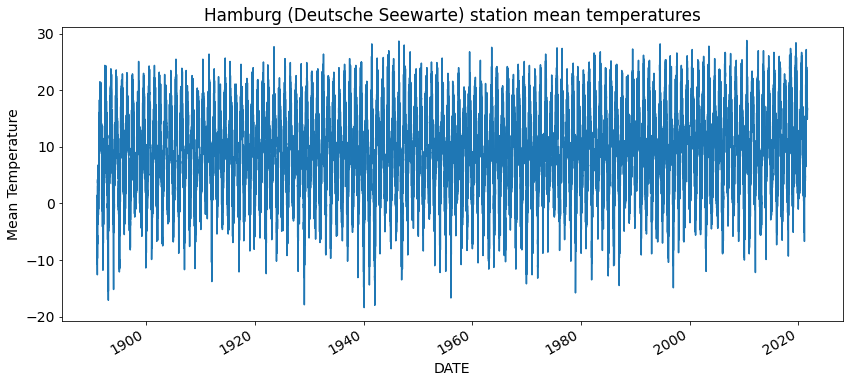

In [14]:
plot_temperature(df=df['Mean Temperatur'], ylim=False)  

### !!! Split in Train and Test !!!

In [15]:
df_train=df[:-365]
df_test=df[-365:]

In [16]:
df_train

,Mean Temperatur,YEAR,MONTH,DAY
DATE,,,,
1891-01-01,-10.7,1891,1,1
1891-01-02,-7.6,1891,1,2
1891-01-03,-10.3,1891,1,3
1891-01-04,-1.3,1891,1,4
1891-01-05,-4.1,1891,1,5
...,...,...,...,...
2020-08-27,15.9,2020,8,27
2020-08-28,16.3,2020,8,28
2020-08-29,16.4,2020,8,29


In [17]:
df_test

,Mean Temperatur,YEAR,MONTH,DAY
DATE,,,,
2020-09-01,15.3,2020,9,1
2020-09-02,14.8,2020,9,2
2020-09-03,13.9,2020,9,3
2020-09-04,17.5,2020,9,4
2020-09-05,15.1,2020,9,5
...,...,...,...,...
2021-08-27,15.1,2021,8,27
2021-08-28,15.2,2021,8,28
2021-08-29,15.8,2021,8,29


# Work with Train data 

###  Make Timesteps

In [18]:
df_train['Timestep'] = list(range(len(df_train)))


<ipython-input-18-f6afd5cda489>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Timestep'] = list(range(len(df_train)))


###  Fit a linear regression on timesteps

In [19]:
X = df_train[['Timestep']]
y = df_train['Mean Temperatur']
m=fit_a_model(X, y, 'linear regression')

Model used:  linear regression


###  Make a Trend

In [20]:
df_train['Trend'] = m.predict(X)  # Use the model to make a prediction

<ipython-input-20-a0059b6ba285>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Trend'] = m.predict(X)  # Use the model to make a prediction


###  Plot raw temperature and the trend

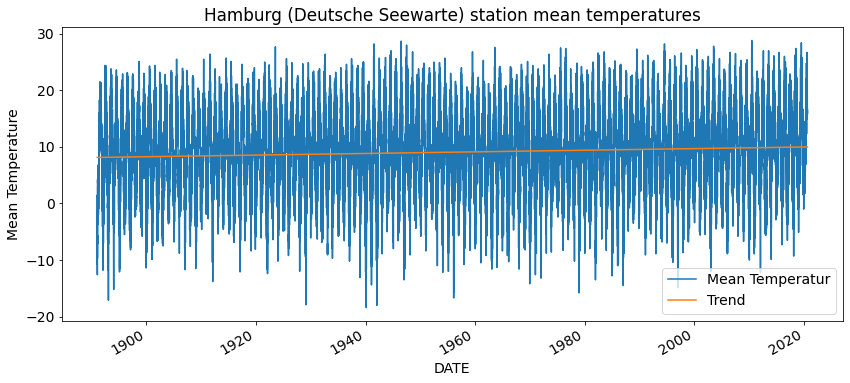

In [21]:
plot_temperature(df_train[['Mean Temperatur','Trend']], ylim =False) 

### Make the seasonality

In [22]:
seasonal_dummies = pd.get_dummies( df_train['MONTH'],prefix='MONTH',drop_first=True) 
df_train = df_train.join(seasonal_dummies)

### Fit linear regression on timesteps and seasons

In [23]:
X = df_train.drop(['Mean Temperatur', 'YEAR', 'MONTH', 'DAY','Trend'],axis=1) 
y= df_train['Mean Temperatur']
m=fit_a_model(X, y, 'linear regression')

Model used:  linear regression


###  Make a Trend Seasonal (trend with seasonality)

In [24]:
df_train['Trend_seasonal'] = m.predict(X)

###   Plot the original data and the trend seasonal

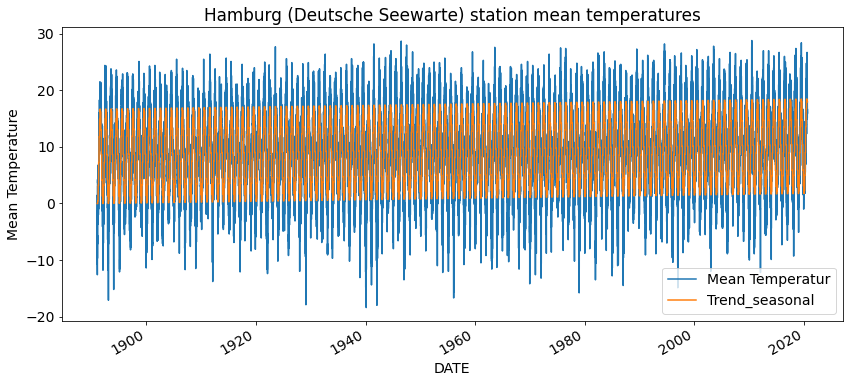

In [25]:
plot_temperature(df_train[['Mean Temperatur','Trend_seasonal']], ylim =False) 

###  Extract the remainder

In [26]:
df_train['Remainder'] = df_train['Mean Temperatur'] - df_train['Trend_seasonal']

In [27]:
df_train['Remainder'].to_csv('ECA_blended_custom_Hamburg/remainder_LG_Hamburg_train.csv')

###  Plot the remainder

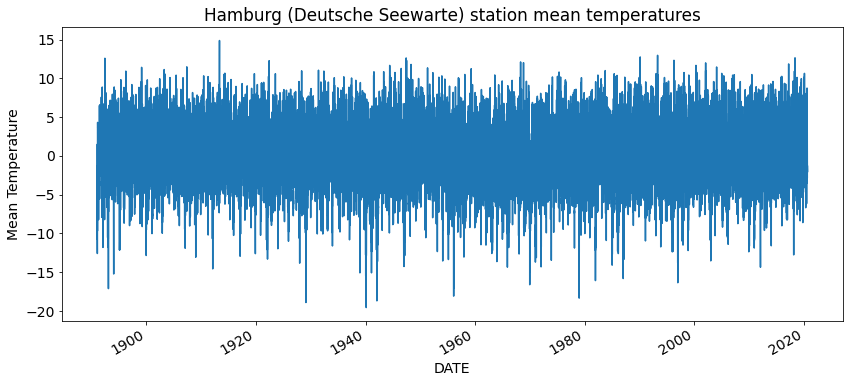

In [28]:
plot_temperature(df_train['Remainder'] ,ylim =False)


###  Add the lags of the remainder to the training data

One lag. See results in Hamburg_Autoregressive_Model.ipynb

In [29]:
df_train['lag1'] = df_train['Remainder'].shift(1)
df_train.dropna(inplace=True)

###  Fit logistic regression on timesteps and lag to create a the 'full model'

In [30]:
X_full = df_train.drop(columns=['Mean Temperatur', 'YEAR','MONTH','DAY','Trend','Trend_seasonal', 'Remainder'])
y_full = df_train['Mean Temperatur']
m_full=fit_a_model(X_full, y_full, 'linear regression')

Model used:  linear regression


###  Make Predictions of the full model

In [31]:
df_train['Predictions_full_model'] = m_full.predict(X_full)

###  Plot raw temperatur, predictions, and trend seasonal

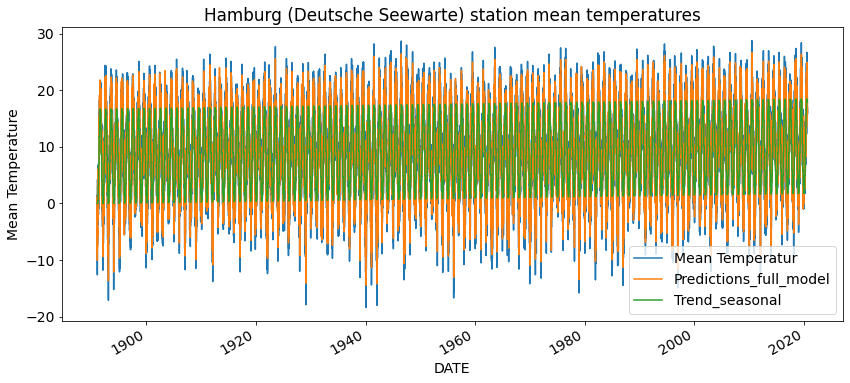

In [32]:
plot_temperature(df_train[['Mean Temperatur',  'Predictions_full_model', 'Trend_seasonal',]], ylim=False)

###  Cross validation of the full model

In [33]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [34]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [35]:
# NOTE: 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.90950936, 0.90623413, 0.89343579, 0.89115116, 0.90068574])

In [36]:
result.mean()

0.9002032378268415

# Work with Test data

###  Make Timesteps

In [37]:
last_train_timestep = df_train['Timestep'][-1]   # Get last timestep of the training data

In [38]:
len_test=len(df_test)

In [39]:
# Create the whole test data
df_test['Timestep'] = list(range(last_train_timestep + 1, 
                            len_test + last_train_timestep + 1))

<ipython-input-39-94b939770dba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Timestep'] = list(range(last_train_timestep + 1,


###  Make the seasonality

In [40]:
seasonal_dummies = pd.get_dummies(df_test.index.month, 
                                  prefix='MONTH', 
                                 drop_first=True).set_index(df_test.index)

df_test = df_test.join(seasonal_dummies)

In [41]:
X_test = df_test.drop(columns=['Mean Temperatur', 'YEAR','MONTH','DAY'])

###  Make a Trend seasonal

In [42]:
df_test['Trend_seasonal'] = m.predict(X_test)


###  Plot raw temperature and Trend seasonal

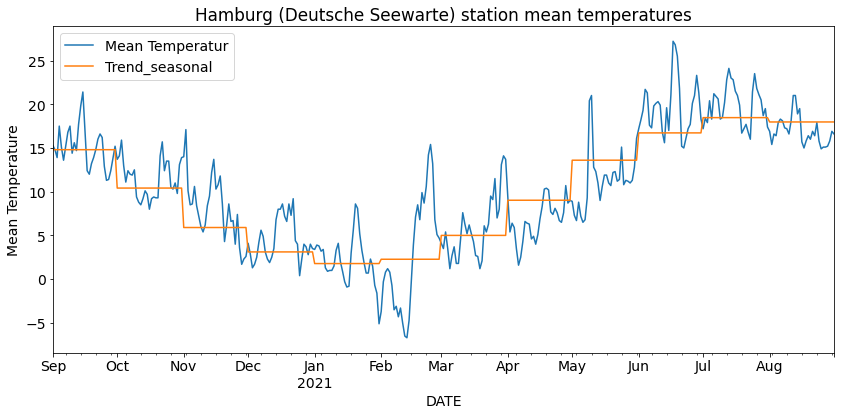

In [43]:
plot_temperature(df_test[['Mean Temperatur', 'Trend_seasonal']], ylim=False)

###  Make Remainder

In [44]:
df_test['Remainder'] = df_test['Mean Temperatur'] - df_test['Trend_seasonal']

###  Make lag

In [45]:
df_test['lag1'] = df_test['Remainder'].shift(1)  

###  Make predictions of the full model

In [46]:
X_full = df_test.drop(columns=['Mean Temperatur', 'YEAR','MONTH','DAY','Trend_seasonal', 'Remainder'])

####  Filling in the missing value from the beginning of the test lag.

In [47]:
X_full.loc['2020-09-01', 'lag1'] = df_train.loc['2020-08-31', 'Remainder'] 

In [48]:
df_test['Predictions_full_model'] = m_full.predict(X_full)

###  Plot raw temperatur, trend seasonal and predictions

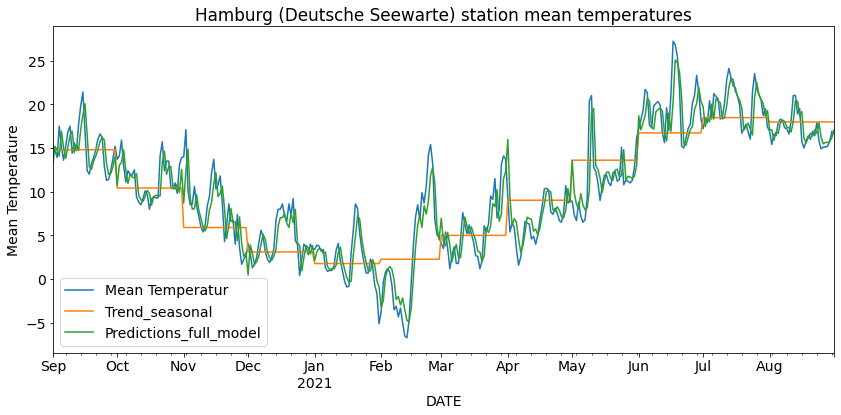

In [49]:
plot_temperature(df_test[['Mean Temperatur', 'Trend_seasonal', 'Predictions_full_model']], ylim=False)

### Plot complete data set

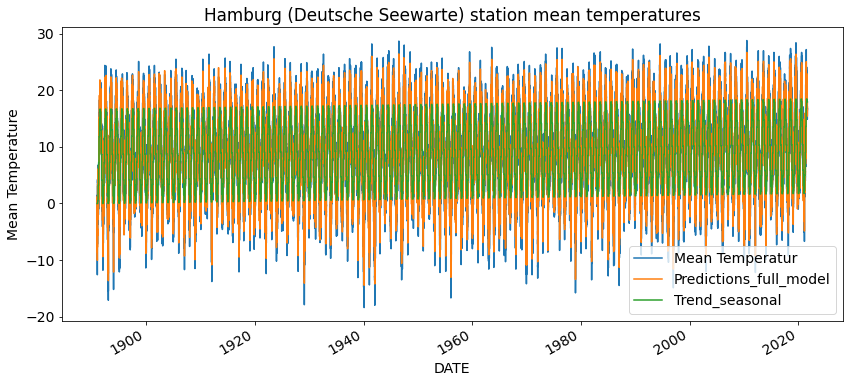

In [50]:
df_full = df_train[['Mean Temperatur', 'Predictions_full_model', 'Trend_seasonal']].append(df_test[['Mean Temperatur', 'Predictions_full_model', 'Trend_seasonal']])
plot_temperature(df_full, ylim=False)

#  Predict the future

In [51]:
df_train = df_train.drop(columns=['YEAR', 'MONTH', 'DAY'])  # Drop not necesary collumns
df_test = df_test.drop(columns=['YEAR', 'MONTH', 'DAY'])

###  Combine Train and Test data sets

In [52]:
df_combined = df_train.append(df_test)
df_combined

,Mean Temperatur,Timestep,Trend,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,Trend_seasonal,Remainder,lag1,Predictions_full_model
DATE,,,,,,,,,,,,,,,,,,
1891-01-02,-7.6,1,8.134725,0,0,0,0,0,0,0,0,0,0,0,-0.016285,-7.583715,-10.683677,-8.528124
1891-01-03,-10.3,2,8.134764,0,0,0,0,0,0,0,0,0,0,0,-0.016247,-10.283753,-7.583715,-6.048682
1891-01-04,-1.3,3,8.134804,0,0,0,0,0,0,0,0,0,0,0,-0.016209,-1.283791,-10.283753,-8.208182
1891-01-05,-4.1,4,8.134843,0,0,0,0,0,0,0,0,0,0,0,-0.016171,-4.083829,-1.283791,-1.009815
1891-01-06,-5.3,5,8.134882,0,0,0,0,0,0,0,0,0,0,0,-0.016133,-5.283867,-4.083829,-3.249297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,15.1,47719,NaN,0,0,0,0,0,0,1,0,0,0,0,17.974308,-2.874308,-2.874270,15.634449
2021-08-28,15.2,47720,NaN,0,0,0,0,0,0,1,0,0,0,0,17.974346,-2.774346,-2.874308,15.634457
2021-08-29,15.8,47721,NaN,0,0,0,0,0,0,1,0,0,0,0,17.974384,-2.174384,-2.774346,15.714446


###  Fit logistic regression on timestep and lag1 of the whole dataset

In [53]:
X_combined = df_combined.drop(columns=['Mean Temperatur','Trend' ,'Trend_seasonal', 'Remainder', 'Predictions_full_model'])
y_combined = df_combined['Mean Temperatur']

####  Filling in the missing value from the beginning of the test lag.

In [54]:
X_combined.loc['2020-09-01', 'lag1'] = df_train.loc['2020-08-31', 'Remainder']

In [55]:
m_combined=fit_a_model(X_combined, y_combined, 'linear regression')

Model used:  linear regression


###  Create a single future step data.

#### First date in the future? --> 2021-08-31

In [56]:
Timestep = df_combined['Timestep'].max() + 1
MONTHS = [0,0,0,0,0,0,1,0,0,0,0]  # MONTH 8
Lag = df_combined.loc['2021-08-31', 'Remainder']

In [57]:
X_future = [Timestep]

In [58]:
X_future.extend(MONTHS)

In [59]:
X_future.append(Lag)

In [60]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns
X_future

,Timestep,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,lag1
0,47724,0,0,0,0,0,0,1,0,0,0,0,-1.374459


In [61]:
m_combined.predict(X_future) # Prediction for 2021-08-31

array([16.8346774])

####  One more step in the future? --> 2021-09-01

In [62]:
Timestep = df_combined['Timestep'].max() + 2
MONTHS = [0,0,0,0,0,0,0,1,0,0,0]  # MONTH 9
Lag = 0 

In [63]:
X_future_2 = pd.DataFrame([[Timestep] + MONTHS + [Lag]])
X_future_2.columns = X_combined.columns
X_future_2

,Timestep,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,lag1
0,47725,0,0,0,0,0,0,0,1,0,0,0,0


In [64]:
m_combined.predict(X_future_2)  # Prediction for 2021-09-01

array([14.80253819])

# Statsmodel AutoReg

In [65]:
from statsmodels.tsa.ar_model import AutoReg

In [66]:
ar_model=AutoReg(endog=df_combined['Remainder'],lags=1).fit()

/home/user/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/user/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [67]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              Remainder   No. Observations:                47723
Model:                     AutoReg(1)   Log Likelihood             -105089.046
Method:               Conditional MLE   S.D. of innovations              2.188
Date:                Fri, 28 Jan 2022   AIC                              1.566
Time:                        10:07:49   BIC                              1.567
Sample:                             1   HQIC                             1.567
                                47723                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0008      0.010      0.082      0.934      -0.019       0.020
Remainder.L1     0.7999      0.003    291.181      0.000       0.794       0.805
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2502           +0.0000j            1.2502            0.0000
-----------------------------------------------------------------------------
"""